# Importing

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"[INFO] importing directory: {dirname}\n")
    with tqdm(total=len(filenames)) as t:
        for filename in filenames:
            t.update(1)

[INFO] importing directory: /kaggle/input



0it [00:00, ?it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation



100%|██████████| 1/1 [00:00<00:00, 10255.02it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Mask



100%|██████████| 290/290 [00:00<00:00, 737627.75it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Image



100%|██████████| 290/290 [00:00<00:00, 537731.28it/s]


In [2]:
#All important imports
import tensorflow as tf
from keras.models import Model

from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
# from skimage.morphology import label
from PIL import Image

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Defining basic file paths
imagesPath = "/kaggle/input/flood-area-segmentation/Image"
masksPath = "/kaggle/input/flood-area-segmentation/Mask"

In [4]:
# Extracting file names as 0.jpg

images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [5]:
# Total images and masks count

print(f"Total images: {len(images_ids)}\nTotal masks: {len(masks_ids)}")

Total images: 290
Total masks: 290


In [6]:
# Creating blank array of the length of image_ids i.e 290, 256, 256, 3

X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

In [7]:
# Resizing the images to 256, 256 and then adding them to the above matrix

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = Image.open(path)
    img = np.array(img)
    img = resize(img, (256, 256, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".png")
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask

Resizing training images and masks


100%|██████████| 290/290 [01:45<00:00,  2.74it/s]


In [8]:
# Printing the shape of the data

print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (290, 256, 256, 3)
Y.shape: (290, 256, 256, 1)


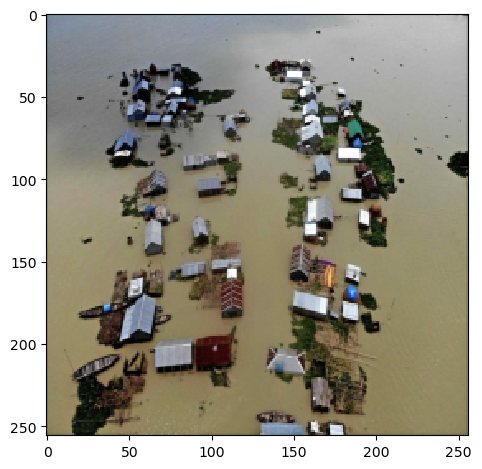

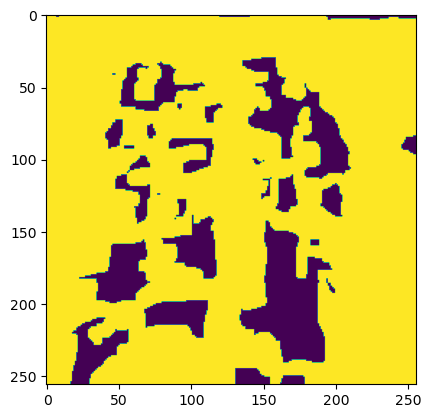

In [9]:
# Plotting random images and their mask

import random
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

# Model

In [10]:
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Activation,Input,SeparableConv2D,GlobalAveragePooling2D,concatenate,ZeroPadding2D, Conv2DTranspose,Add,Reshape,Lambda
from tensorflow.keras.initializers import glorot_uniform
from PIL import Image
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Cropping2D

In [11]:
inputs=Input((256,256,3))

s =Lambda(lambda x: x / 256)(inputs)

#block-1
# c1=Conv2D(16,(1,1),padding='same',activation='relu')(inputs)
# c1=BatchNormalization()(c1)

# c1=Activation('relu')(c1)

#block-2
c2=Conv2D(16,(3,3),padding='same')(s)
c2=BatchNormalization()(c2)
c2=tf.nn.relu(c2)
c2=Activation('relu')(c2)
c2=Conv2D(16,(3,3),padding='same')(c2)
c2=BatchNormalization()(c2)
c2=Conv2D(16,(3,3),padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)

#block-3
c3=Conv2D(32,(3,3),padding='same')(p2)
c3=BatchNormalization()(c3)
c3=tf.nn.relu(c3)
c3=Activation('relu')(c3)
c3=Conv2D(32,(3,3),padding='same')(c3)
c3=BatchNormalization()(c3)
c3=Conv2D(32,(3,3),padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)

#block-4
c4=tf.nn.relu(p3)
c4=Conv2D(32,(3,3),padding='same')(c4)
c4=BatchNormalization()(c4)
c4=tf.nn.relu(c4)
c4=Conv2D(32,(3,3),padding='same')(c4)
c4=BatchNormalization()(c4)
c4=tf.nn.relu(c4)
c4=Conv2D(32,(3,3),padding='same')(c4)

#block-5
c5=Conv2D(64,(3,3),padding='same')(c4)
c5=BatchNormalization()(c5)
c5=tf.nn.relu(c5)
c5=Conv2D(64,(3,3),padding='same')(c5)
c5=BatchNormalization()(c5)
c5=Conv2D(64,(3,3),padding='same')(c5)
p5=MaxPooling2D((2,2))(c5)

#block-6
c6=Conv2D(128,(3,3),padding='same')(p5)
c6=tf.nn.relu(c6)
c6=Conv2D(128,(3,3),padding='same')(c6)
c6=BatchNormalization()(c6)
c6=Conv2D(128,(3,3),padding='same')(c6)
p6=MaxPooling2D((2,2))(c6)

#block-7
c7=Conv2D(256,(3,3),padding='same')(p6)
c7=tf.nn.relu(c7)
c7=Conv2D(256,(3,3),padding='same')(c7)
c7=BatchNormalization()(c7)
c7=Conv2D(256,(3,3),padding='same')(c7)
p7=MaxPooling2D((2,2))(c7)

#block-8
c8=Conv2D(256,(3,3),padding='same')(p7)
c8=tf.nn.relu(c8)
c8=Conv2D(256,(3,3),padding='same')(c8)
c8=BatchNormalization()(c8)
c8=Conv2D(256,(3,3),padding='same')(c8)
p8=MaxPooling2D((2,2))(c8)

#block-9
c9=Conv2D(256,(3,3),padding='same')(p8)
c9=tf.nn.relu(c9)
c9=Conv2D(256,(3,3),padding='same')(c9)
c9=BatchNormalization()(c9)
c9=Conv2D(256,(3,3),padding='same')(c9)
p9=MaxPooling2D((2,2))(c9)

#block-10
c10=Conv2D(256,(3,3),padding='same')(p9)
c10=tf.nn.relu(c10)
c10=Conv2D(256,(3,3),padding='same')(c10)
c10=BatchNormalization()(c10)
c10=Conv2D(256,(3,3),padding='same')(c10)
p10=MaxPooling2D((2,2))(c10)

#block-11
c11=tf.nn.relu(p10)
c11=Conv2D(512,(3,3),padding='same')(c11)
c11=BatchNormalization()(c11)
c11=tf.nn.relu(c11)
c11=Conv2D(512,(3,3),padding='same')(c11)
c11=BatchNormalization()(c11)
c11=tf.nn.relu(c11)
c11=Conv2D(512,(3,3),padding='same')(c11)
c11=BatchNormalization()(c11)

#block-12 - back-1
u12=Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c11)
u12 = concatenate([u12, c10])
c12 = tf.nn.relu(u12)
c12=Conv2D(256,(3,3),padding='same')(c12)
c12=BatchNormalization()(c12)
c12=tf.nn.relu(c12)
c12=Conv2D(256,(3,3),padding='same')(c12)
c12=BatchNormalization()(c12)
c12=tf.nn.relu(c12)
c12=Conv2D(256,(3,3),padding='same')(c12)
c12=BatchNormalization()(c12)

#block-13 - back-2
u13=Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c12)
u13=concatenate([u13,c9])
c13=tf.nn.relu(u13)
c13=Conv2D(256,(3,3),padding='same')(c13)
c13=BatchNormalization()(c13)
c13=tf.nn.relu(c13)
c13=Conv2D(256,(3,3),padding='same')(c13)
c13=BatchNormalization()(c13)
c13=tf.nn.relu(c13)
c13=Conv2D(256,(3,3),padding='same')(c13)
c13=BatchNormalization()(c13)

#block-14 - back-3
u14=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c13)
u14=concatenate([u14,c8])
c14=tf.nn.relu(u14)
c14=Conv2D(128,(3,3),padding='same')(c14)
c14=BatchNormalization()(c14)
c14=tf.nn.relu(c14)
c14=Conv2D(128,(3,3),padding='same')(c14)
c14=BatchNormalization()(c14)
c14=tf.nn.relu(c14)
c14=Conv2D(128,(3,3),padding='same')(c14)
c14=BatchNormalization()(c14)

#block-15 - back-4
u15=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c14)
u15=concatenate([u15,c7])
c15=tf.nn.relu(u15)
c15=Conv2D(64,(3,3),padding='same')(c15)
c15=BatchNormalization()(c15)
c15=tf.nn.relu(c15)
c15=Conv2D(64,(3,3),padding='same')(c15)
c15=BatchNormalization()(c15)
c15=tf.nn.relu(c15)
c15=Conv2D(64,(3,3),padding='same')(c15)
c15=BatchNormalization()(c15)

#block-16 - back-5
u16=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c15)
u16=concatenate([u16,c6])
c16=tf.nn.relu(u16)
c16=Conv2D(32,(3,3),padding='same')(c16)
c16=BatchNormalization()(c16)
c16=tf.nn.relu(c16)
c16=Conv2D(32,(3,3),padding='same')(c16)
c16=BatchNormalization()(c16)
c16=tf.nn.relu(c16)
c16=Conv2D(32,(3,3),padding='same')(c16)
c16=BatchNormalization()(c16)

#block-17 - back-6
u17=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c16)
u17=concatenate([u17,c5])
c17=tf.nn.relu(u17)
c17=Conv2D(16,(3,3),padding='same')(c17)
c17=BatchNormalization()(c17)
c17=tf.nn.relu(c17)
c17=Conv2D(16,(3,3),padding='same')(c17)
c17=BatchNormalization()(c17)
c17=tf.nn.relu(c17)
c17=Conv2D(16,(3,3),padding='same')(c17)
c17=BatchNormalization()(c17)

#block-18 - back-7
u18=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c17)
u18=concatenate([u18,c3])
c18=tf.nn.relu(u18)
c18=Conv2D(16,(3,3),padding='same')(c18)
c18=BatchNormalization()(c18)
c18=tf.nn.relu(c18)
c18=Conv2D(16,(3,3),padding='same')(c18)
c18=BatchNormalization()(c18)
c18=tf.nn.relu(c18)
c18=Conv2D(16,(3,3),padding='same')(c18)
c18=BatchNormalization()(c18)

#block-19 - back-7
u19=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c18)
u19=concatenate([u19,c2])
c19=tf.nn.relu(u19)
c19=Conv2D(16,(3,3),padding='same')(c19)
c19=BatchNormalization()(c19)
c19=tf.nn.relu(c19)
c19=Conv2D(16,(3,3),padding='same')(c19)
c19=BatchNormalization()(c19)
c19=tf.nn.relu(c19)
c19=Conv2D(16,(3,3),padding='same')(c19)
c19=BatchNormalization()(c19)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c19)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

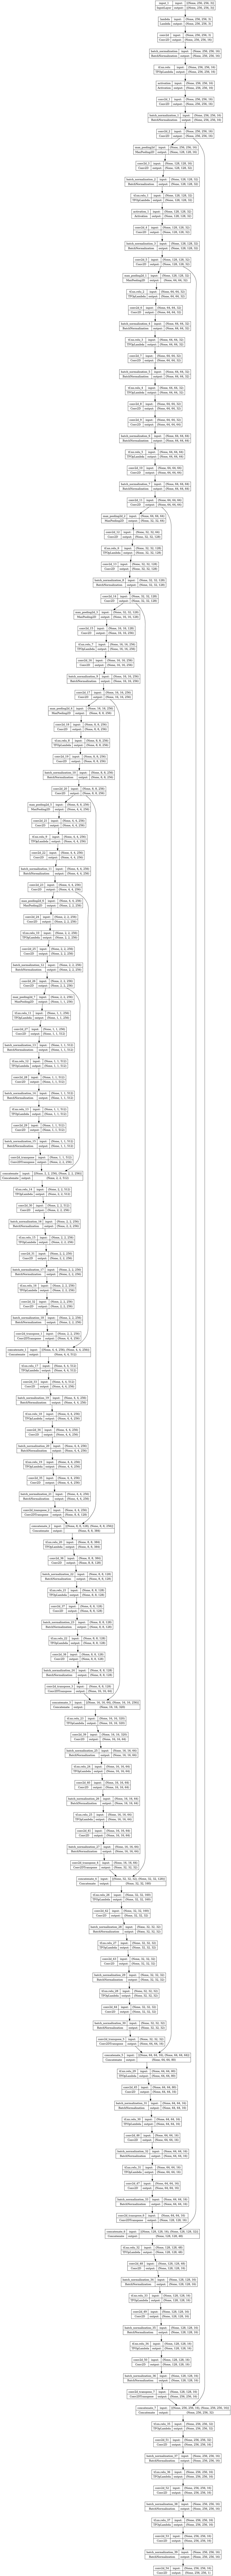

In [13]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
Image(filename='model.png')

In [14]:
callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = model.fit(X, Y, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 50s 176ms/step - loss: 0.4918 - accuracy: 0.7617 - val_loss: 0.8163 - val_accuracy: 0.4460
Epoch 2/50
33/33 [==============================] - 2s 73ms/step - loss: 0.4431 - accuracy: 0.8011 - val_loss: 0.9898 - val_accuracy: 0.4464
Epoch 3/50
33/33 [==============================] - 2s 76ms/step - loss: 0.4109 - accuracy: 0.8187 - val_loss: 1.4775 - val_accuracy: 0.4461
Epoch 4/50
33/33 [==============================] - 2s 75ms/step - loss: 0.3953 - accuracy: 0.8278 - val_loss: 1.4084 - val_accuracy: 0.4462
Epoch 5/50
33/33 [==============================] - 2s 73ms/step - loss: 0.3905 - accuracy: 0.8317 - val_loss: 2.4738 - val_accuracy: 0.4577
Epoch 6/50
33/33 [==============================] - 2s 75ms/step - loss: 0.4022 - accuracy: 0.8275 - val_loss: 2.4835 - val_accuracy: 0.4518
Epoch 7/50
33/33 [==============================] - 2s 74ms/step - loss: 0.3896 - accuracy: 0.8274 - val_loss: 1.4739 - val_accuracy: 0.4709
Epoch 8/50


# Plotting

In [15]:
# Function to plot the training curve with the best model indication

def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

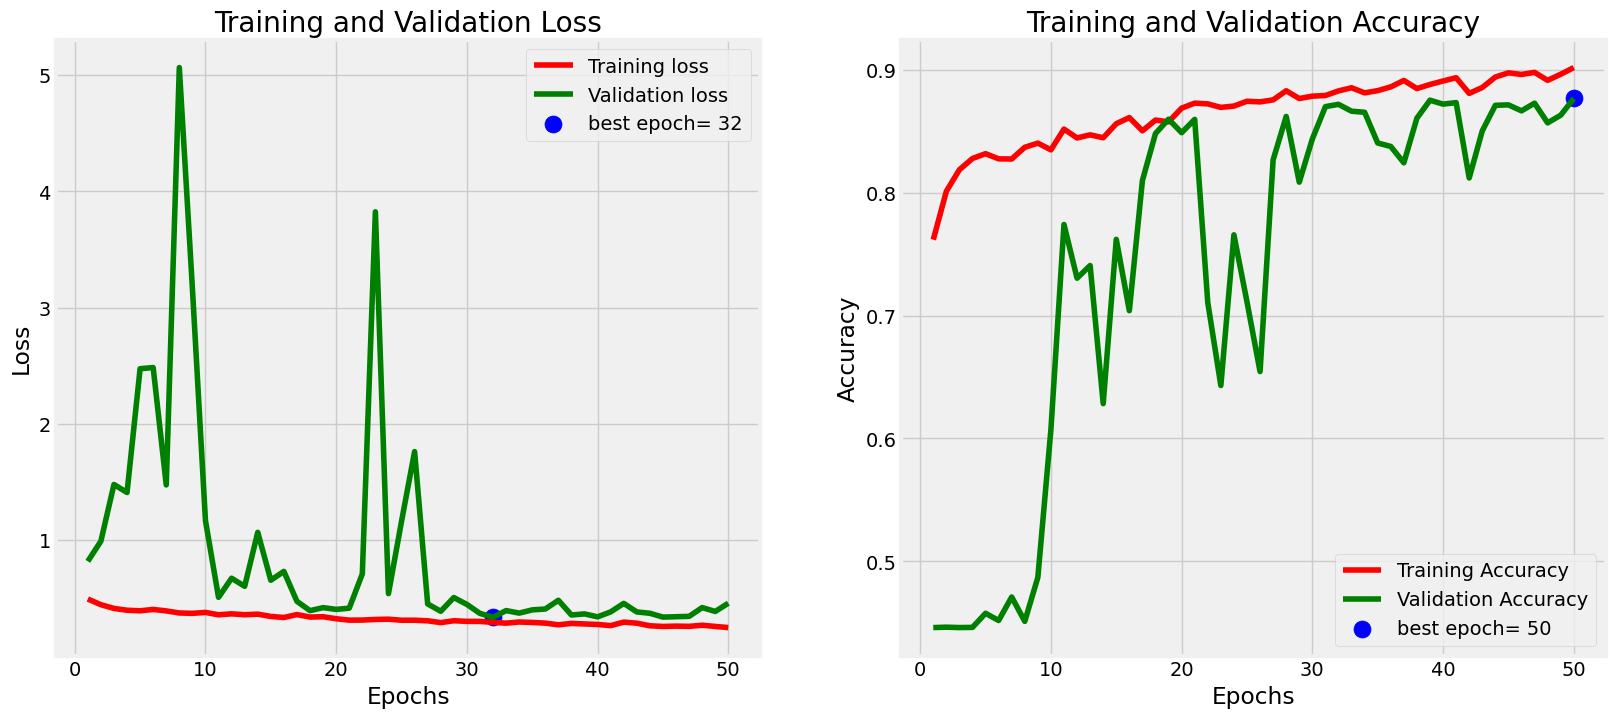

In [16]:
plot_training(results)

In [17]:
model.save('model.h5')

In [18]:
model.evaluate(X, Y)

10/10 [==============================] - 3s 133ms/step - loss: 0.3132 - accuracy: 0.8915


[0.3131890296936035, 0.8915168642997742]

<Figure size 3000x3000 with 0 Axes>

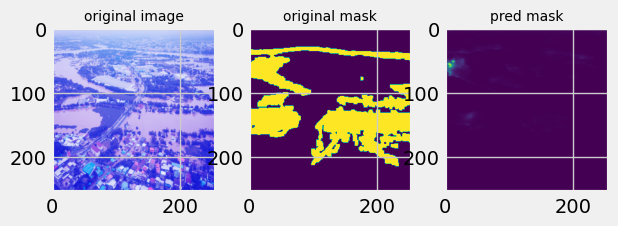

In [19]:
# displaying random image, mask, and predicted mask

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))